In [ ]:
from datasets import load_from_disk
from trl import DPOConfig, DPOTrainer
from transformers import AutoModelForCausalLM, AutoTokenizer
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

import torch

from peft import PeftModel

In [ ]:
MODEL_ID = "google/gemma-3-12b-it"
MODEL_CACHE_DIRECTORY = "./llm_models_cache"

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    cache_dir=MODEL_CACHE_DIRECTORY,
    device_map="cuda",
    trust_remote_code=True,
)

# Enable gradient checkpointing to trade compute for memory
model.gradient_checkpointing_enable()

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_ID,
    cache_dir=MODEL_CACHE_DIRECTORY,
    trust_remote_code=True,
)

train_dataset = load_from_disk("further_dpo_dataset_gemma3_12b_250_epochs")

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [5]:
# Check max token length of the chosen code
max_chosen_code_length = max([len(tokenizer.encode(item['chosen'])) for item in train_dataset])
print(f"Max chosen code length: {max_chosen_code_length}")

Max chosen code length: 376


In [6]:
max_rejected_code_length = max([len(tokenizer.encode(item['rejected'])) for item in train_dataset])
print(f"Max rejected code length: {max_rejected_code_length}")

Max rejected code length: 525


In [ ]:
# Memory-optimized DPO training configuration
training_args = DPOConfig(
    output_dir="GEMMA3_4B_DPO_FURTHER",

    per_device_train_batch_size=1,        
    gradient_accumulation_steps=16,        
    max_length=1024,                 
    max_prompt_length=1024,
    learning_rate=5e-7,
    num_train_epochs=250,

    gradient_checkpointing=True,
    dataloader_pin_memory=False,
    
    logging_steps=1,
    save_steps=50,
    
    remove_unused_columns=True,
    ddp_find_unused_parameters=False,
)

In [11]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters before PEFT: {total_params}")

Total parameters before PEFT: 12187325040


In [ ]:
lora_model = PeftModel.from_pretrained(
    model,
    "./gemma-3-12b-dpo-250-epochs",
    device_map="cuda"
    )

total_params = sum(p.numel() for p in lora_model.parameters())
print(f"Total parameters after PEFT: {total_params}")

Total parameters after PEFT: 12255781488


In [13]:
# Make sure lora adapters are trainable
for name, param in lora_model.named_parameters():
    if 'lora_' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [ ]:
# Complete memory-optimized DPO training setup
import gc

# Clear any existing models from memory
gc.collect()
torch.cuda.empty_cache() if torch.cuda.is_available() else None

# Create trainer with optimized settings
trainer = DPOTrainer(
    model=lora_model,  # Use LoRA model instead of full model
    args=training_args,  # Use optimized training arguments
    processing_class=tokenizer,
    train_dataset=train_dataset,
)

print("Trainer created")
print(f"Trainable parameters: {sum(p.numel() for p in lora_model.parameters() if p.requires_grad)}")

if torch.cuda.is_available():
    print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU memory reserved: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

Trainer created.
Trainable parameters: 68456448
GPU memory allocated: 45.66 GB
GPU memory reserved: 46.78 GB


In [ ]:
trainer.train()

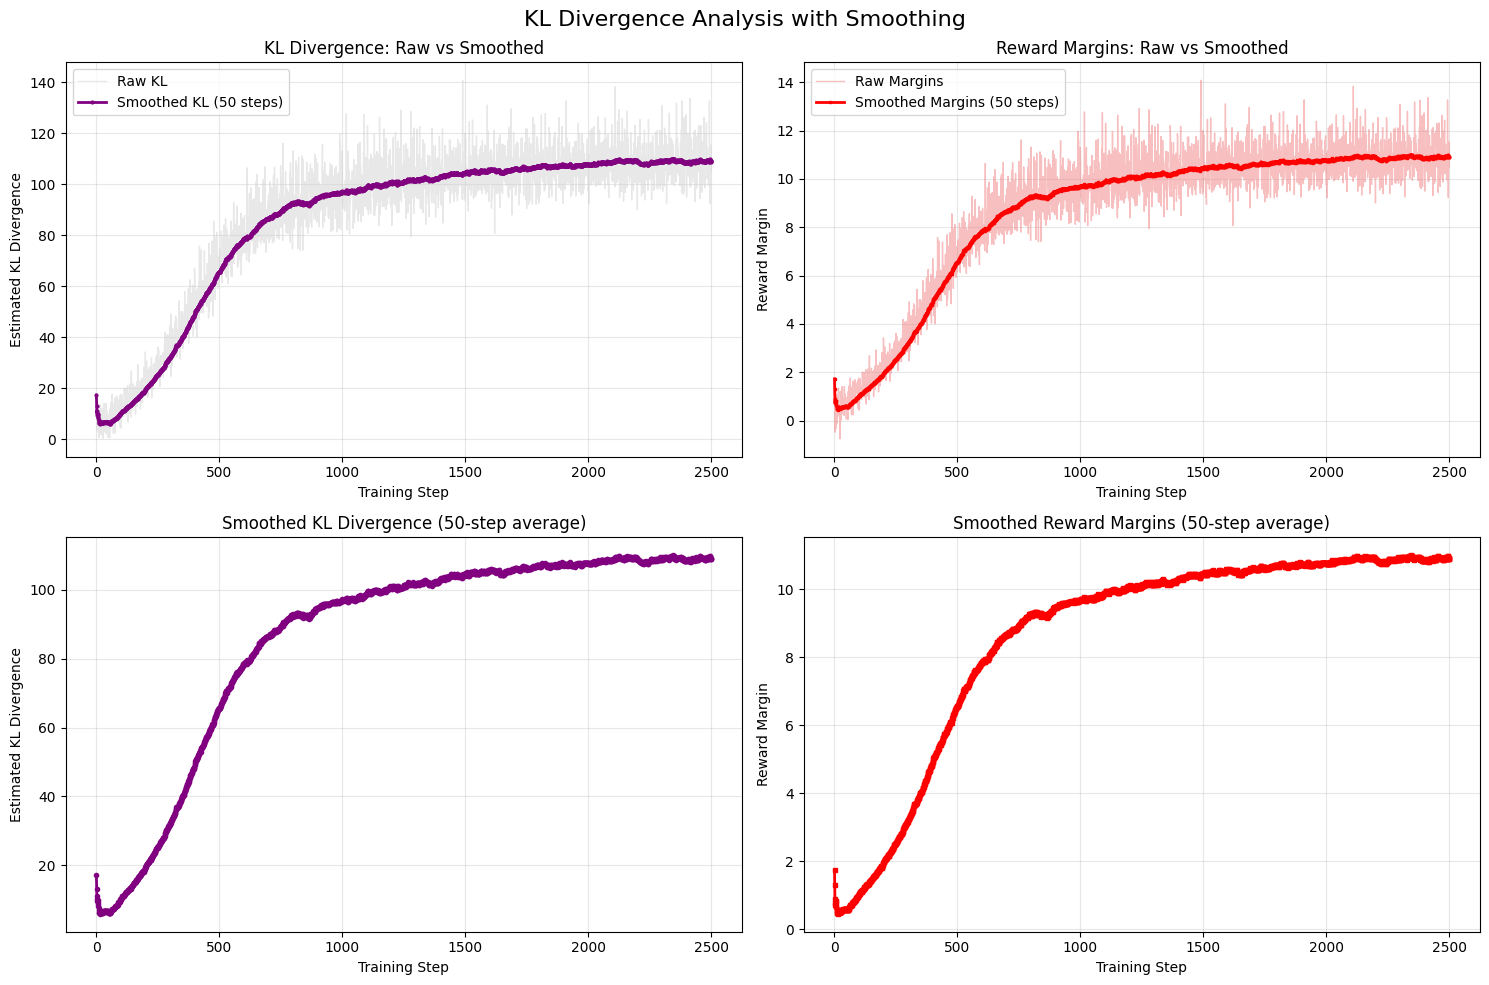


📊 KL Divergence Statistics:
   Raw KL - Mean: 87.316933, Max: 140.784130, Final: nan
   Smoothed KL - Mean: 86.337688, Max: 110.028452, Final: 109.007791
   Raw Margins - Mean: 8.730294, Std: 3.105118
   Smoothed Margins - Mean: 8.631060, Std: 3.107605


In [ ]:
# Compute KL divergence using DPO theory with smoothing
def compute_theoretical_kl_from_dpo_loss(train_logs, beta=0.1, smooth_window=50):
    """
    Estimate KL divergence using DPO loss theory with smoothing
    
    In DPO: loss = -log(σ(β * (log π(y_w|x) - log π(y_l|x) - log π_ref(y_w|x) + log π_ref(y_l|x))))
    
    The KL divergence is related to the difference in log probabilities
    """
    
    if 'loss' in train_logs.columns and 'rewards/margins' in train_logs.columns:
        
        # Extract components
        loss = train_logs['loss']
        reward_margin = train_logs['rewards/margins']
        
        # Approximate KL using the relationship in DPO
        # In DPO, the implicit reward is r(x,y) = β * log(π(y|x)/π_ref(y|x)) + constant
        # So KL ≈ reward_margin / β
        
        estimated_kl = np.abs(reward_margin) / beta
        
        # Apply smoothing using rolling average
        estimated_kl_smooth = estimated_kl.rolling(window=smooth_window, min_periods=1).mean()
        reward_margin_smooth = reward_margin.rolling(window=smooth_window, min_periods=1).mean()
        
        return estimated_kl, estimated_kl_smooth, reward_margin, reward_margin_smooth
    
    return None, None, None, None

logs = trainer.state.log_history
df = pd.DataFrame(logs)
train_logs = df[df['step'].notna()].copy()

# Compute theoretical KL with smoothing
raw_kl, smooth_kl, raw_margins, smooth_margins = compute_theoretical_kl_from_dpo_loss(
    train_logs, beta=0.1, smooth_window=50
)

if smooth_kl is not None:
    plt.figure(figsize=(15, 10))
    
    # Plot 1: KL Divergence - Raw vs Smoothed
    plt.subplot(2, 2, 1)
    plt.plot(train_logs['step'], raw_kl, 'lightgray', alpha=0.5, linewidth=1, label='Raw KL')
    plt.plot(train_logs['step'], smooth_kl, 'purple', linewidth=2, marker='o', markersize=2, label='Smoothed KL (50 steps)')
    plt.title('KL Divergence: Raw vs Smoothed')
    plt.xlabel('Training Step')
    plt.ylabel('Estimated KL Divergence')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Reward Margins - Raw vs Smoothed  
    plt.subplot(2, 2, 2)
    plt.plot(train_logs['step'], raw_margins, 'lightcoral', alpha=0.5, linewidth=1, label='Raw Margins')
    plt.plot(train_logs['step'], smooth_margins, 'red', linewidth=2, marker='s', markersize=2, label='Smoothed Margins (50 steps)')
    plt.title('Reward Margins: Raw vs Smoothed')
    plt.xlabel('Training Step')
    plt.ylabel('Reward Margin')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Smoothed KL only (cleaner view)
    plt.subplot(2, 2, 3)
    plt.plot(train_logs['step'], smooth_kl, 'purple', linewidth=2, marker='o', markersize=3)
    plt.title('Smoothed KL Divergence (50-step average)')
    plt.xlabel('Training Step')
    plt.ylabel('Estimated KL Divergence')
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Smoothed Margins only (cleaner view)
    plt.subplot(2, 2, 4)
    plt.plot(train_logs['step'], smooth_margins, 'red', linewidth=2, marker='s', markersize=3)
    plt.title('Smoothed Reward Margins (50-step average)')
    plt.xlabel('Training Step')
    plt.ylabel('Reward Margin')
    plt.grid(True, alpha=0.3)
    
    plt.suptitle('KL Divergence Analysis with Smoothing', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print KL statistics for both raw and smoothed
    print(f"\n📊 KL Divergence Statistics:")
    print(f"   Raw KL - Mean: {raw_kl.mean():.6f}, Max: {raw_kl.max():.6f}, Final: {raw_kl.iloc[-1]:.6f}")
    print(f"   Smoothed KL - Mean: {smooth_kl.mean():.6f}, Max: {smooth_kl.max():.6f}, Final: {smooth_kl.iloc[-1]:.6f}")
    print(f"   Raw Margins - Mean: {raw_margins.mean():.6f}, Std: {raw_margins.std():.6f}")
    print(f"   Smoothed Margins - Mean: {smooth_margins.mean():.6f}, Std: {smooth_margins.std():.6f}")
    
else:
    print("Cannot compute theoretical KL - missing required metrics")

In [ ]:
# Save the fine-tuned LoRA model
lora_model.save_pretrained("gemma-3-12b-dpo-250-epochs-further-250-epochs")